# DENUE information

@roman

6 July, 2024

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import h3
from tqdm import tqdm
from dotenv import load_dotenv
from scipy.spatial import KDTree
# dbscan
from sklearn.cluster import DBSCAN
from INEGIpy import DENUE, MarcoGeoestadistico

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

# Load environment variables
load_dotenv()

# inegi class
denue_api = DENUE(token=os.getenv('API_INEGI'))
inegi_api = MarcoGeoestadistico()


In [3]:
# params
ESTRATO_CATEGORIES = [
    '0 a 5 personas',
    '6 a 10 personas',
    '11 a 30 personas',
    '31 a 50 personas',
    '51 a 100 personas',
    '101 a 250 personas',
    '251 y más personas'
]

IMPORTANT_VARS_DENUE = [
    'CLEE', 'Nombre', 'Razon_social', 'Clase_actividad', 'estrato_category',
    'CLASE_ACTIVIDAD_ID', 'SUBRAMA_ACTIVIDAD_ID', 'AreaGeo', 'state_id',
    'Fecha_Alta', 'geometry'
]

---
# Data

## Properties

## Mexico

In [4]:
# get mexico shapes
gdf_mexico = inegi_api.Entidades()
gdf_mexico.shape

(32, 9)

---
# DENUE's Data

In [5]:
# search denue's data
def get_denue_units(list_of_names, activity_id, max_units=100_000):
    # fetch each name
    list_units_df = []

    for name in tqdm(list_of_names):
        gdf = denue_api.BuscarAreaAct(
            nombre=name,
            clave_area='00',
            registro_inicial=0,
            registro_final=max_units,
            estrato='0'
        )
        list_units_df.append(gdf)
    
    # concat
    df_append = pd.concat(list_units_df, axis=0)

    # filter by CLASE_ACTIVIDAD_ID in activity_id
    mask = df_append['CLASE_ACTIVIDAD_ID'].isin(activity_id)
    df_append = (
        df_append
        .loc[mask]
        # drop
        .drop_duplicates('CLEE', keep='first')
        .query("Tipo == 'Fijo'")  # we want always fixed units
        # format
        .assign(
            estrato_category=lambda x: pd.Categorical(
                x['Estrato'],
                categories=ESTRATO_CATEGORIES,
                ordered=True
            ),
            Razon_social=lambda x: 
                x['Razon_social'].str.strip().str.upper(),
            state_id=lambda x: x['AreaGeo'].str[:2],
            Fecha_Alta=lambda x: pd.to_datetime(
                x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
        )
        # drop columns
        .loc[:, IMPORTANT_VARS_DENUE]
        .reset_index(drop=True)
    )
    
    return df_append


def plot_denues(gdf, title='DENUE'):
    # plot
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, color='C0', markersize=1)
    # add titles
    plt.title(f'{title} units')
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # show
    plt.show()


def denue_eda(gdf, title='DENUE'):
    # s2: count razon social
    print(f"\n {'='*10}Razon social {'='*10}")
    print(gdf['Razon_social'].value_counts(normalize=True).head(10))

    # s3 count estrato
    print(f"\n {'='*10}Estrato {'='*10}")
    print(gdf['estrato_category'].value_counts(normalize=True).sort_index())

    # s1: plot map
    plot_denues(gdf, title)

    # s4: plot ts
    fig, ax = plt.subplots(figsize=(8, 4))
    gdf.groupby('Fecha_Alta').size().cumsum().plot(ax=ax, drawstyle='steps-post')
    # add titles
    plt.title(f'{title} units time series')
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Units')
    # ylim in 0
    plt.ylim(0, None)
    # show
    plt.show()

    # s5: plot state_id
    fig, ax = plt.subplots(figsize=(8, 4))
    gdf['state_id'].value_counts(normalize=True).sort_index().plot(kind='bar')
    # add titles
    plt.title(f'{title} units by state')
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Percentage')
    # y ticks in %
    ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
    # show
    plt.show()
    return None

    


## Supermarkets

### Fetch

In [6]:
# get supermarkets
list_names = [
    'supermercado'
]

acivity_ids = [
    '462111',  # super comercio al por menor
]

# fetch
gdf_supermarkets = get_denue_units(list_names, acivity_ids)

# see the data
print(gdf_supermarkets.shape)
gdf_supermarkets.sample(5)

100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

(7179, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,state_id,Fecha_Alta,geometry
3978,05030462111000093000010698S3,LEY EXPRESS SALTILLO 2000 1175,CASA LEY SAPI DE CV,Comercio al por menor en supermercados,31 a 50 personas,462111,46211,050300001,05,2010-07-01,POINT (-101.02524 25.46541)
3821,05035462111000316000008465S7,HEB SUCURSAL INDEPENDENCIA 2970,SUPERMERCADOS INTERNACIONALES HEB SA DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,050350001,05,2010-07-01,POINT (-103.43102 25.56235)
2825,28038462111000042000002514S6,BODEGA MULTIPLAZA REAL 3073,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,280380001,28,2010-07-01,POINT (-97.86683 22.31583)
4634,17028462111000013001002514S1,MI BODEGA XOCHITEPEC CENTRO 1980,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,31 a 50 personas,462111,46211,170280001,17,2014-12-01,POINT (-99.23310 18.79184)
2404,09015462111000755000002514S4,BODEGA AURRERA EXPRESS NIÑOS HEROES DE CHAP 3156,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,51 a 100 personas,462111,46211,090140001,09,2024-05-01,POINT (-99.14674 19.38877)


In [7]:
# important supermarkets
important_supermarkets = [
    'NUEVA WAL MART DE MEXICO S DE RL DE CV',
    'TIENDAS SORIANA SA DE CV',
    'TIENDAS CHEDRAUI SA DE CV',
    'CASA LEY SAPI DE CV',
    'QAR SUPERMERCADOS SAPI DE CV',
    'CORPORACION SANCHEZ SA DE CV',
    'COMERCIAL CITY FRESKO S DE RL DE CV',
    'OPERADORA FUTURAMA SA DE CV',
    'SUPERMERCADOS INTERNACIONALES HEB SA DE CV',
    'SUPERISSSTE',
    'INSTITUTO MEXICANO DEL SEGURO SOCIAL',
    'SUPER SAN FRANCISCO DE ASIS SA DE CV',
    'COSTCO DE MEXICO SA DE CV'
]

# filter
gdf_supermarkets = (
    gdf_supermarkets
    .query("Razon_social in @important_supermarkets")
    .query("estrato_category >= '11 a 30 personas'")
    .reset_index(drop=True)
)

# see
print(gdf_supermarkets.shape)

(4647, 11)


/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_38779/2932614701.py:22: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("estrato_category >= '11 a 30 personas'")


### EDA


 ==========Razon social ==========
Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        0.574779
TIENDAS SORIANA SA DE CV                      0.174091
TIENDAS CHEDRAUI SA DE CV                     0.069077
CASA LEY SAPI DE CV                           0.052077
QAR SUPERMERCADOS SAPI DE CV                  0.021519
COMERCIAL CITY FRESKO S DE RL DE CV           0.018937
OPERADORA FUTURAMA SA DE CV                   0.018291
SUPERMERCADOS INTERNACIONALES HEB SA DE CV    0.014848
CORPORACION SANCHEZ SA DE CV                  0.014848
SUPERISSSTE                                   0.012266
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.000000
6 a 10 personas       0.000000
11 a 30 personas      0.242737
31 a 50 personas      0.086723
51 a 100 personas     0.285991
101 a 250 personas    0.365827
251 y más personas    0.018722
Name: proportion, dtype: float64


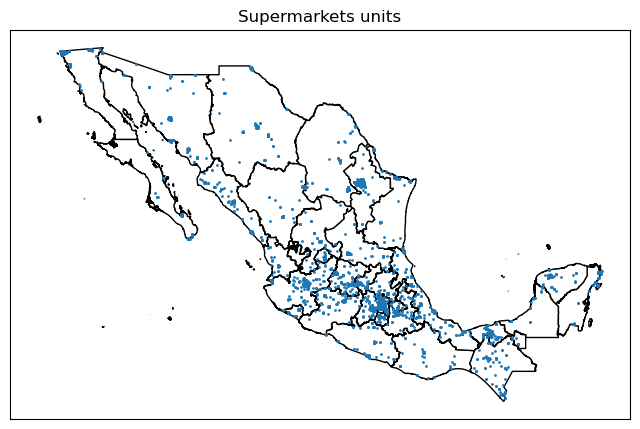

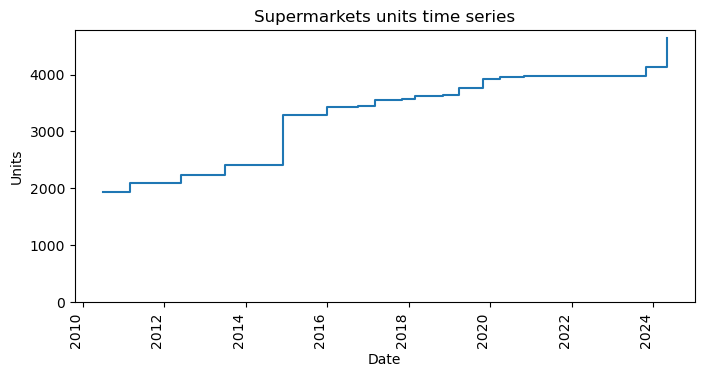

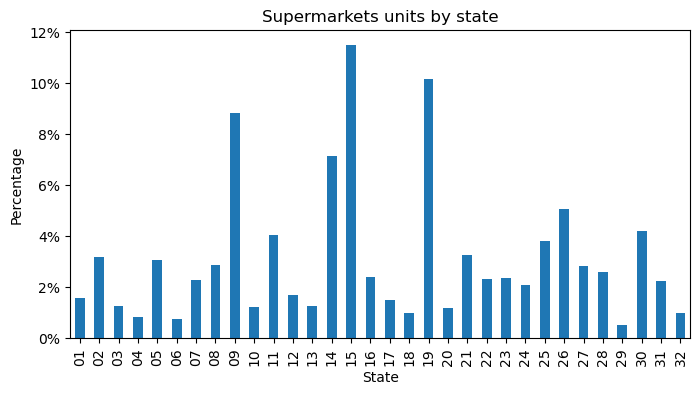

In [8]:
# eda
denue_eda(gdf_supermarkets, 'Supermarkets')

## Hospitals

In [9]:
# get hospitals
list_names = [
    'hospitales'
]

activity_ids = [
    '622111',  # private hospitals
    '622112',  # public hospitals
]

# fetch
gdf_hospitals = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_hospitals.shape)
gdf_hospitals.sample(5)

100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

(4626, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,state_id,Fecha_Alta,geometry
1530,20067622111000093001000000U3,HOSPITAL CLINICA MEDICA QUIRURGICA SAN JUANITO,,Hospitales generales del sector privado,6 a 10 personas,622111,62211,200670001,20,2010-07-01,POINT (-96.73604 17.05204)
2606,10005622111000163000000000U6,HOSPITAL SANTA BARBARA DEL RIETI,HOSPITAL SANTA BARBARA DEL RIETI SA DE CV,Hospitales generales del sector privado,11 a 30 personas,622111,62211,100050001,10,2014-12-01,POINT (-104.66326 24.03514)
4534,19009622111000041000000000U7,UNIDAD MEDICA SAN MIGUEL,,Hospitales generales del sector privado,0 a 5 personas,622111,62211,190090001,19,2019-11-01,POINT (-100.00223 25.58601)
566,16053622111000132000000000U5,CLÍNICA 26 DE JULIO,SECRETARIA DE DESARROLLO HUMANO Y BIENESTAR SO...,Hospitales generales del sector público,6 a 10 personas,622112,62211,160530001,16,2010-07-01,POINT (-101.25061 19.71211)
3837,14067622111000143000000000U4,SERVICIOS MEDICOS DE LA BAHIA DEL PUERTO,SERVICIOS MEDICOS DE LA BAHIA DEL PUERTO SA DE CV,Hospitales generales del sector privado,11 a 30 personas,622111,62211,140670001,14,2023-11-01,POINT (-105.22980 20.62606)


In [10]:
# filter
gdf_hospitals = (
    gdf_hospitals
    .query("estrato_category >= '251 y más personas'")
    .reset_index(drop=True)
)

# see
print(gdf_hospitals.shape)

(670, 11)


/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_38779/214999184.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("estrato_category >= '251 y más personas'")


### EDA


 ==========Razon social ==========
Razon_social
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                          0.158209
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO    0.043284
                                                                              0.037313
OPERADORA DE HOSPITALES ANGELES SA DE CV                                      0.035821
IMSS                                                                          0.029851
GOBIERNO FEDERAL                                                              0.023881
GOBIERNO                                                                      0.020896
PETROLEOS MEXICANOS                                                           0.019403
SECRETARIA DE SALUD                                                           0.017910
SERVICIOS DE SALUD DE VERACRUZ                                                0.011940
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category


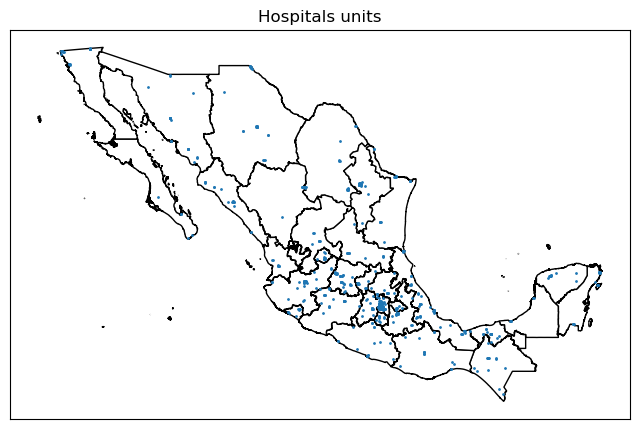

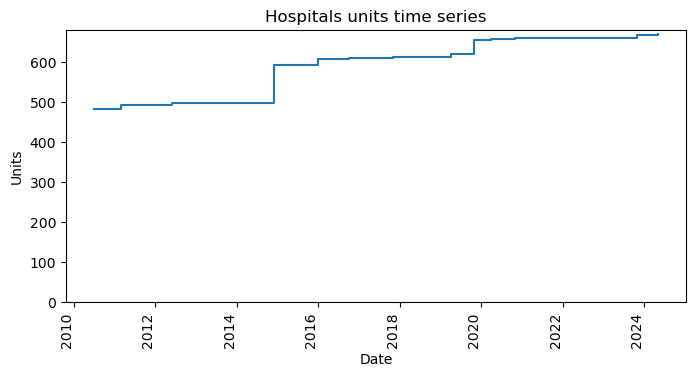

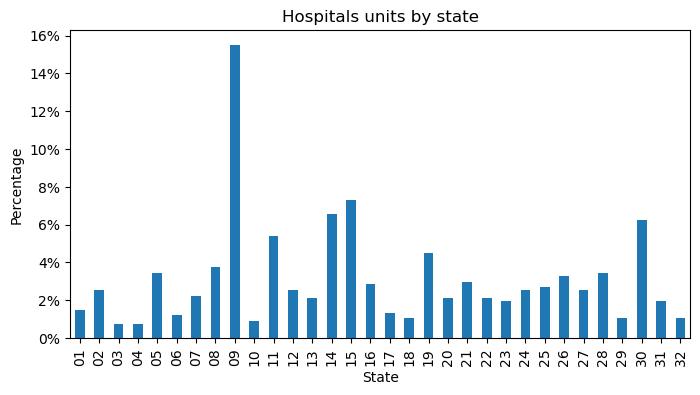

In [11]:
# eda
denue_eda(gdf_hospitals, 'Hospitals')

## Metro

This one is more artesanal

### Fetch

In [12]:
# get metro
list_names = [
    'metro'
]

activity_ids = [
    '485114',  # metro
]

# fetch
gdf_metro = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_metro.shape)
gdf_metro.sample(5)

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

(413, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,state_id,Fecha_Alta,geometry
261,15033485114000031000014124S2,ESTACION DEL METRO PLAZA ARAGON,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,150330001,15,2023-11-01,POINT (-99.03011 19.52883)
317,09015485114000941000014124S7,ESTACION DEL METRO TEPITO,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090150001,09,2023-11-01,POINT (-99.12411 19.44285)
388,09003485114000031000000000U3,METROBUS,CONCESIONADO AL SISTEMA DE CORREDORES DE TRANS...,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090030001,09,2014-12-01,POINT (-99.18918 19.32003)
400,09011485114000181000014124S9,PUESTO CENTRAL DE LINEA DEL METRO TLAHUAC,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090110001,09,2023-11-01,POINT (-99.04497 19.31179)
90,09015485114000591000014124S0,ESTACION DEL METRO BUENAVISTA,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090150001,09,2023-11-01,POINT (-99.15741 19.43662)


### Filtering

In [13]:
# see cve_ents
gdf_metro['AreaGeo'].str[:2].value_counts()

AreaGeo
09    351
19     35
15     23
11      3
14      1
Name: count, dtype: int64

In [14]:
# drop rows with cve_ents eq to 11 or 14
mask = gdf_metro['AreaGeo'].str[:2].isin(['11', '14'])
gdf_metro = gdf_metro[~mask].reset_index(drop=True)
gdf_metro.shape

(409, 11)

In [15]:
# explore
gdf_metro.loc[:, ['Nombre', 'geometry']].explore(tiles='CartoDB positron')

^^^
there are more than 1 metro stations in the same location, we need to cluster them

### Clean

In [16]:
# get longitude & latitude
gdf_metro = gdf_metro.to_crs('EPSG:6372')
gdf_metro['longitude'] = gdf_metro.centroid.x
gdf_metro['latitude'] = gdf_metro.centroid.y
# return to 4326
gdf_metro = gdf_metro.to_crs('EPSG:4326')

In [17]:
# use dbscan to cluster metro stations
eps = 250 # meters
min_samples = 2

# get clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
gdf_metro['cluster'] = dbscan.fit_predict(gdf_metro[['latitude', 'longitude']])

In [18]:
# see clusters
gdf_metro['cluster'].value_counts()

cluster
-1      86
 3       9
 101     8
 1       6
 113     5
        ..
 55      2
 53      2
 51      2
 50      2
 130     2
Name: count, Length: 132, dtype: int64

In [19]:
# get only first observation for each cluster
gdf_metro_unique_clusters = gdf_metro.query("cluster == -1").copy()
gdf_metro_multiple_clusters = gdf_metro.query("cluster != -1").drop_duplicates('cluster', keep='first').copy()

# for multiple clusters, get the average of latitude and longitude
gdf_metro_multiple_clusters['longitude'] = gdf_metro_multiple_clusters.groupby('cluster')['longitude'].transform('mean')
gdf_metro_multiple_clusters['latitude'] = gdf_metro_multiple_clusters.groupby('cluster')['latitude'].transform('mean')

# join
gdf_metro2 = pd.concat([gdf_metro_unique_clusters, gdf_metro_multiple_clusters], axis=0)
gdf_metro2.shape

# set new geometry
gdf_metro2['geometry'] = gdf_metro2.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
gdf_metro2 = gpd.GeoDataFrame(gdf_metro2, geometry='geometry', crs='EPSG:6372')

# change crs
gdf_metro2 = gdf_metro2.to_crs('EPSG:4326')


In [20]:
# explore
gdf_metro2.loc[:, ['Nombre', 'geometry']].explore(tiles='CartoDB positron')

### EDA


 ==========Razon social ==========
Razon_social
SISTEMA DE TRANSPORTE COLECTIVO METRO                                                        0.834101
SISTEMA DE TRANSPORTE COLECTIVO METRORREY                                                    0.147465
ESTACION DEL MEXIBUS LINEA 2                                                                 0.004608
FERROCARRILES SUBURBANOS SAPI DE CV                                                          0.004608
SISTEMA DE TRANSPORTE DE PASAJEROS GOBIERNO DEL DISTRITO FEDERAL                             0.004608
CONCESIONADO AL SISTEMA DE CORREDORES DE TRANSPORTE PÚBLICO DEL DISTRITO FEDERAL METROBUS    0.004608
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.764977
6 a 10 personas       0.124424
11 a 30 personas      0.069124
31 a 50 personas      0.013825
51 a 100 personas     0.018433
101 a 250 personas    0.000000
251 y más personas    0.009217
Name: proportion, dtype: float64


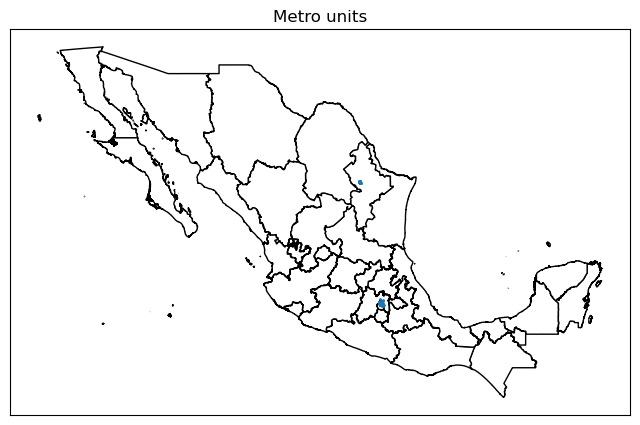

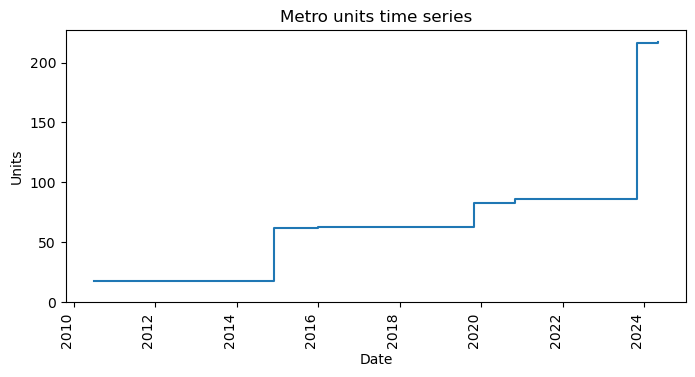

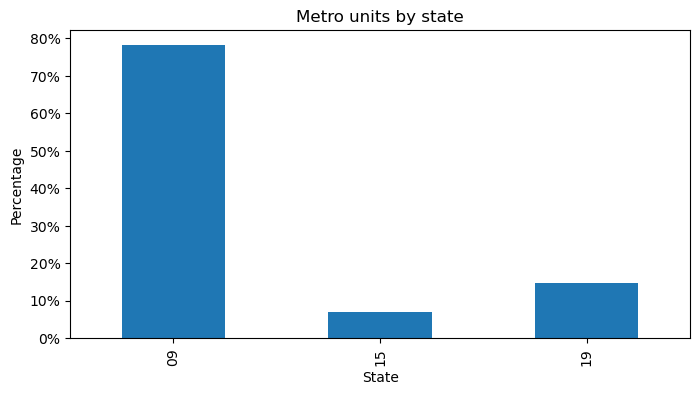

In [21]:
# eda
denue_eda(gdf_metro2, 'Metro')

## Schools

In [22]:
# schools
list_names = [
    'universidad', 'escuela', 'colegio', 'instituto', 'campus'
]

activity_ids = [
    '611311',  # private universities
    '611312',  # public schools
]

# fetch
gdf_schools = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_schools.shape)
gdf_schools.sample(5)

100%|██████████| 5/5 [01:11<00:00, 14.23s/it]


(7351, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,state_id,Fecha_Alta,geometry
1770,15118611311000046000044440M8,UNIEM,UNIVERSIDAD INTERCULTURAL EJECUTIVA DE MEXICO AC,Escuelas de educación superior del sector privado,101 a 250 personas,611311,61131,151180060,15,2019-11-01,POINT (-99.70383 19.29424)
1148,24028611312000094000000000U6,INSTITUTO DE CIENCIAS EDUCATIVAS DE LA UASLP,UNIVERSIDAD AUTONOMA DE SAN LUIS POTOSÍ,Escuelas de educación superior del sector público,11 a 30 personas,611312,61131,240280001,24,2010-07-01,POINT (-100.99055 22.13772)
5462,09005611312000076000000000U0,ESCUELA NACIONAL DE BIBLIOTECONOMIA Y ARCHIVON...,SECRETARIA DE EDUCACION PUBLICA,Escuelas de educación superior del sector público,101 a 250 personas,611312,61131,090050001,09,2010-07-01,POINT (-99.13318 19.51101)
6294,30193611311000462001009562S1,INSTITUTO DE ESTUDIOS UNIVERSITARIOS SC PLANTE...,INSTITUTO DE ESTUDIOS UNIVERSITARIOS SC,Escuelas de educación superior del sector privado,11 a 30 personas,611311,61131,301930001,30,2017-11-01,POINT (-96.12130 19.17595)
5685,05031611312000011000000000U7,ESCUELA SUPERIOR DE AGRICULTURA Y VETERINARIA ...,SECRETARIA DE EDUCACION PUBLICA,Escuelas de educación superior del sector público,6 a 10 personas,611312,61131,050310001,05,2010-07-01,POINT (-101.53669 27.06184)


In [23]:
# filter
gdf_schools = (
    gdf_schools
    .query("estrato_category >= '251 y más personas'")  # big universities
    .query("Razon_social != '' & Nombre != ''")  # should be named
    .reset_index(drop=True)
)

# see
print(gdf_schools.shape)
gdf_schools.sample(5)

(499, 11)


/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_38779/2167353877.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("estrato_category >= '251 y más personas'")  # big universities


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,state_id,Fecha_Alta,geometry
165,24028611311000225002057300M8,UNIVERSIDAD CUAUHTEMOC PLANTEL SAN LUIS POTOSI,UNIVERSIDAD CUAUHTEMOC PLANTEL SAN LUIS POTOSI AC,Escuelas de educación superior del sector privado,251 y más personas,611311,61131,240280001,24,2010-07-01,POINT (-101.00901 22.14050)
179,20059611312000027000000000U5,UNIVERSIDAD DE LA SIERRA SUR,UNIVERSIDAD DE LA SIERRA SUR,Escuelas de educación superior del sector público,251 y más personas,611312,61131,200590001,20,2019-11-01,POINT (-96.57896 16.34477)
39,02001541721000017000000000U7,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y SOCIALES,UNIVERSIDAD AUTONOMA DE BAJA CALIFORNIA,Escuelas de educación superior del sector público,251 y más personas,611312,61131,020010001,02,2010-07-01,POINT (-116.59896 31.82567)
395,28003611311000057000011971M4,IEST,INSTITUTO DE ESTUDIOS SUPERIORES DE TAMAULIPAS AC,Escuelas de educación superior del sector privado,251 y más personas,611311,61131,280030122,28,2010-07-01,POINT (-97.87985 22.32341)
340,19039611311002127000057911S8,CENTRO DE EXTENCION MONTERREY,FORMACION UNIVERSITARIA Y HUMANISTA DE LA LAGU...,Escuelas de educación superior del sector privado,251 y más personas,611311,61131,190390001,19,2023-11-01,POINT (-100.34144 25.67843)


### EDA

In [24]:
# count CLASE_ACTIVIDAD_ID
gdf_schools['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
611312    308
611311    191
Name: count, dtype: int64


 ==========Razon social ==========
Razon_social
TECNOLOGICO NACIONAL DE MEXICO                                 0.054108
INSTITUTO POLITÉCNICO NACIONAL                                 0.048096
UNIVERSIDADES TECNOLOGICAS Y POLITÉCNICAS                      0.044088
UNIVERSIDAD DEL DESARROLLO PROFESIONAL SC                      0.038076
UNIVERSIDAD DEL VALLE DE MEXICO SC                             0.036072
UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO                        0.030060
INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES DE MONTERREY    0.022044
UNIVERSIDAD TECNOLOGICA DE MEXICO SC                           0.020040
SECRETARIA DE EDUCACION PÚBLICA                                0.018036
UNIVERSIDAD DE GUADALAJARA                                     0.018036
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.0
6 a 10 personas       0.0
11 a 30 personas      0.0
31 a 50 personas      0.0
51 a 100 personas     0.0
101 a 250 personas  

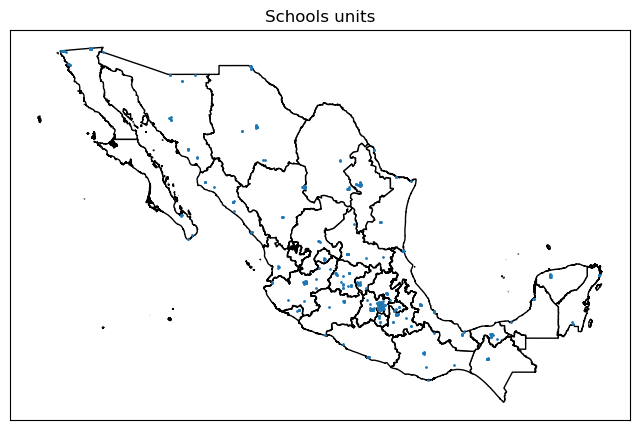

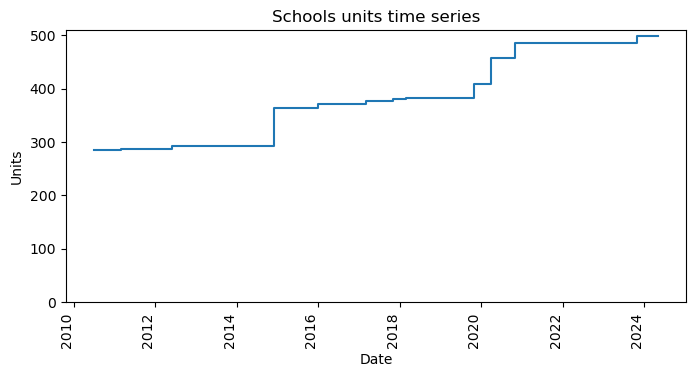

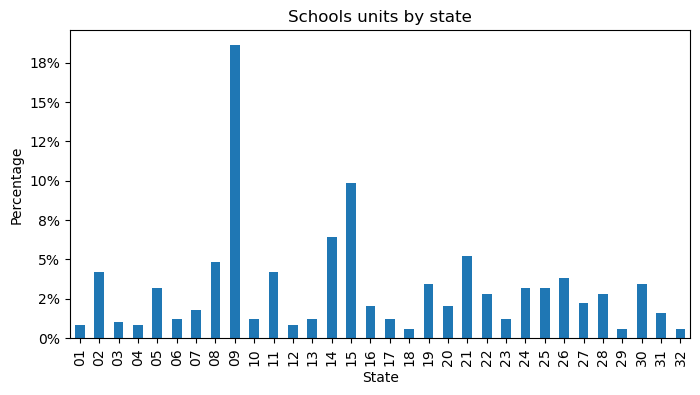

In [25]:
# general eda
denue_eda(gdf_schools, 'Schools')

## Restaurants

In [26]:
# get restaurants
list_names = [
    'restaurante', 'cafeteria', 'sushi', 'comida'
]

activity_ids = [
    '722511',  # restaurants
    '722512',  # seafood restaurants
]

# fetch
gdf_restaurants = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_restaurants.shape)

100%|██████████| 4/4 [02:57<00:00, 44.30s/it]


(65664, 11)


In [27]:
# filter
# mask
mask = (
    gdf_restaurants['Nombre'].ne('')  # known name
    & gdf_restaurants['estrato_category'].ge('6 a 10 personas')
    & gdf_restaurants['estrato_category'].le('51 a 100 personas') 
    & gdf_restaurants['Razon_social'].ne('')  # known razon social
)
gdf_restaurants = gdf_restaurants[mask].reset_index(drop=True)

# see
print(gdf_restaurants.shape)
gdf_restaurants.sample(5)

(8192, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,state_id,Fecha_Alta,geometry
5952,21197722110000153000000000U0,RESTAURANTE LA CHOZA 1986,LA CHOZA 1986 SA DE CV,Restaurantes con servicio de preparación de al...,6 a 10 personas,722511,72251,211970001,21,2010-07-01,POINT (-97.95718 20.27616)
3746,20067722511000143000000000S6,MCCARTHY S IRISH PUB,GRUPO FEMANISA SA DE CV,Restaurantes con servicio de preparación de al...,11 a 30 personas,722511,72251,200670001,20,2014-12-01,POINT (-96.71970 17.07609)
7492,09012722110000411001002563S9,TOKS,RESTAURANTES TOKS SA DE CV,Restaurantes con servicio de preparación de al...,31 a 50 personas,722511,72251,090120001,09,2010-07-01,POINT (-99.15677 19.29426)
8045,05030722511001173000000000U9,WING STOP,OPERADORA LAGUNA FOOD S DE RL DE CV,Restaurantes con servicio de preparación de al...,11 a 30 personas,722511,72251,050300001,05,2016-01-01,POINT (-100.96334 25.46391)
2043,15106722511004472000000000U8,EL HERRADERO,VERDADERO SABOR A MEXICO SA DE CV,Restaurantes con servicio de preparación de al...,6 a 10 personas,722511,72251,151060001,15,2023-11-01,POINT (-99.65839 19.28725)


### EDA


 ==========Razon social ==========
Razon_social
OPERADORA VIPS S DE RL DE CV                       0.027832
RESTAURANTES TOKS SA DE CV                         0.025024
GASTRO SUR SA DE CV                                0.007446
LAS NUEVAS DELICIAS GASTRONOMICAS S DE RL DE CV    0.005737
RESTAURANTE LAS ALITAS SA DE CV                    0.005249
FLY BY WINGS SA DE CV                              0.005127
NOVALIMENTOS DE MEXICO S DE RL DE CV               0.004150
GMA OPERADORA DE FRANQUICIAS SAPI DE CV            0.003540
AEROCOMIDAS SA DE CV                               0.003296
SUSHI ROLL SA DE CV                                0.003052
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.000000
6 a 10 personas       0.231567
11 a 30 personas      0.448120
31 a 50 personas      0.188477
51 a 100 personas     0.131836
101 a 250 personas    0.000000
251 y más personas    0.000000
Name: proportion, dtype: float64


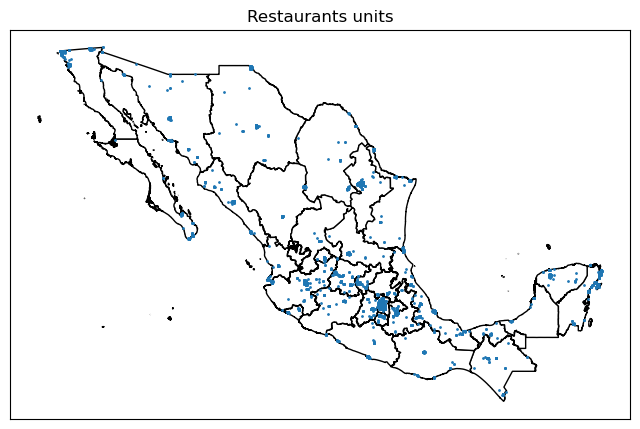

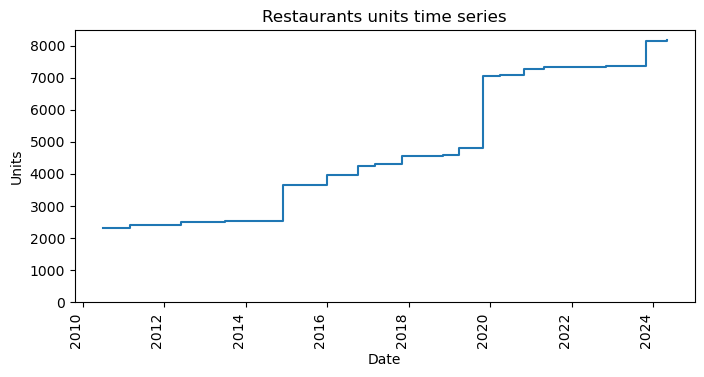

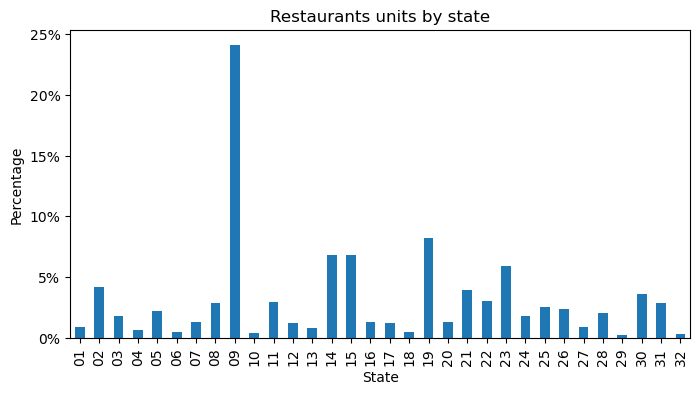

In [28]:
# general eda
denue_eda(gdf_restaurants, 'Restaurants')

## Concat All

In [29]:
# append all into one
gdf_denue = pd.concat([
    gdf_supermarkets.assign(category='supermarkets'),
    gdf_hospitals.assign(category='hospitals'),
    gdf_metro2.assign(category='metro'),
    gdf_schools.assign(category='schools'),
    gdf_restaurants.assign(category='restaurants')
], axis=0)

# delete longitude, latitude and cluster
gdf_denue = gdf_denue.drop(columns=['longitude', 'latitude', 'cluster'])

# see
print(gdf_denue.shape)
gdf_denue.sample(5)

(14225, 12)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,state_id,Fecha_Alta,geometry,category
128,26030622112000227000000000U7,HOSPITAL DE GINECOPEDIATRIA,INSTITUTO NACIONAL DEL SEGURO SOCIAL IMSS,Hospitales generales del sector público,251 y más personas,622112,62211,260300001,26,2010-07-01,POINT (-110.95250 29.10531),hospitals
1627,25001462111000011000002514S2,BODEGA HOSPITAL GENERAL 1006,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,250010001,25,2010-07-01,POINT (-108.99004 25.77083),supermarkets
3849,21174722511000053000000000U0,MI VIEJO CAFE RESTAURANTE,GASTRONOMICA CENTRAL DE TEZIUTLAN SA DE CV,Restaurantes con servicio de preparación de al...,11 a 30 personas,722511,72251,211740001,21,2014-12-01,POINT (-97.36058 19.81624),restaurants
1366,15106722511002012000028189S4,MR SUSHI TOLUCA,RENTASU MEXICANA SA DE CV,Restaurantes con servicio de preparación de al...,6 a 10 personas,722511,72251,151060086,15,2016-01-01,POINT (-99.62164 19.29118),restaurants
1430,14098722511001022000000000U4,SUSHI AKEMI,SUSHI AKEMI,Restaurantes con servicio de preparación de al...,6 a 10 personas,722511,72251,140980001,14,2019-11-01,POINT (-103.28805 20.63264),restaurants


In [30]:
# see crs
gdf_denue.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: xlabel='state_id'>

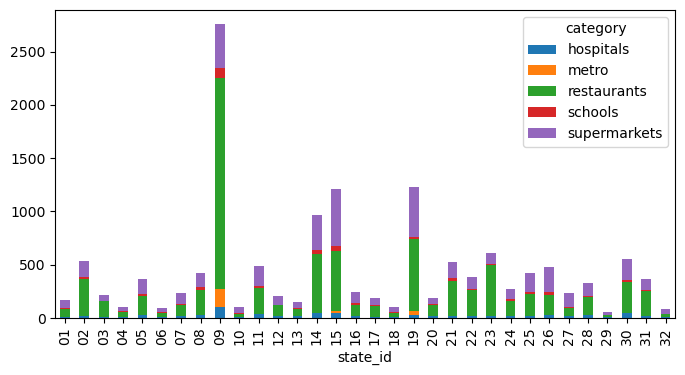

In [31]:
# count category by state
gdf_denue.groupby(['state_id', 'category']).size().unstack().plot(kind='bar', stacked=True, figsize=(8, 4))

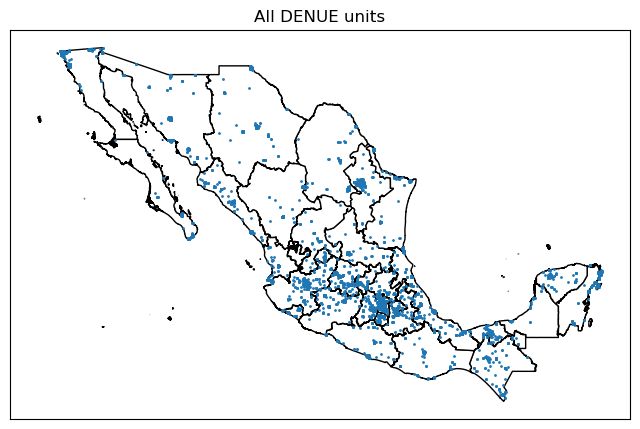

In [32]:
# plot
plot_denues(gdf_denue, 'All DENUE')

In [33]:
# count unique clee
gdf_denue['CLEE'].nunique()

14225

## Save

In [34]:
# save data into misc
dir_save = '../../data/misc'
os.makedirs(dir_save, exist_ok=True)

# save
gdf_denue.to_parquet(f'{dir_save}/denue_data.parquet')